# Does  spring low always coencide with morning in Cape Town?

Last night a good friend and respectable sea man told me that in Cape Town the spring low is unfailingly in the morning. 
I believe him. However, let's see if we can work out if this is true! 


In [1]:
# Imports 

import requests
import arrow
import os
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
# import stormglass_excess_apis
from io import StringIO




Okay, let's collect a bunch of tide data, mostly the time that tides happen.


In [2]:
# # Describe our one constant
# TODAY = arrow.get(date.today())
# # Pull as much historical data as we can.
# # We need to loop over this a bunch of times. Stormglass only allows you to pull 10 days at a time.
# # You get 10 requests per key, so this is 100 days per key. 
# # We have 10 keys, so we have 1000 days of information.
# # Get all 1k days.
# # Save that all to a csv so you can 

# # This sets the day to today, start will be the placeholder for each run. 
# start = TODAY
# main_df = pd.DataFrame()
# # This loops through the api keys. I know it is dirty, but I couln't find a way to get os.getenv to work
# for key, value in stormglass_excess_apis.api_dict.items():
#     api_key = value
#     print('starting',api_key)
#     # Loops through each key 10 times.
#     for counter in range(1, 11):
#         print('Getting Data for',start)
#         # sets the caller back by 10 days
#         start = start.shift(days=-10)
#         response = requests.get(
#             "https://api.stormglass.io/v2/tide/extremes/point",
#             params={
#                 "lat": -34.402377,
#                 "lng": 18.251149,
#                 "start": start.shift(days=-10).to("UTC").timestamp(),  # Convert to UTC timestamp
#                 "end": start.to("UTC").timestamp()
#             },
#             headers={"Authorization": api_key},
#             ).json()
#         print('re',response)
#         # Splits out the data that is useful for us and makes it a dataframe
#         for key, value in response.items():
#             data = response["data"]
#         df = pd.DataFrame.from_dict(data)
#         # Adds this dataframe to an overarching dataframe
#         main_df = pd.concat([main_df, df])

# # Confirms everything went well and outputs one large csv of all the data
# print("Full collection of Data\n", main_df)
# # main_df.to_csv("data/raw_tide_csv.csv", index=False)



Now we're getting somewhere, we have all the tide changes for the past 1000 days loaded into our computer. <br>
Let's strip some stuff out. Starting with the high tides, we don't need those.

In [3]:
# Opens the saved tides
tides = pd.read_csv('data/raw_tide_csv.csv')

# Drops all the high tides. 
tides.drop(tides[tides['type']=='high'].index, inplace = True)

# Sorts the data by least recent to most.
tides['date'] = pd.to_datetime(tides['time']).dt.date
# Convert the 'time' column to a datetime object, extract date
tides['time'] = pd.to_datetime(tides['time']).dt.time
# Order the data from oldest to newest
tides = tides.sort_values(by=['date','time'])

tides['date'] = pd.to_datetime(tides['date'])


# tides.to_csv('data/low_tide_csv.csv',index=False)
tides



,height,time,type,date
3439,-0.351179,03:06:00,low,2020-11-10
3441,-0.443033,15:53:00,low,2020-11-10
3443,-0.453352,04:05:00,low,2020-11-11
3445,-0.579502,16:44:00,low,2020-11-11
3447,-0.559946,04:54:00,low,2020-11-12
...,...,...,...,...
29,-0.240229,10:45:00,low,2023-04-26
31,-0.116569,23:31:00,low,2023-04-26
33,-0.156992,12:13:00,low,2023-04-27
35,-0.100414,02:17:00,low,2023-04-28


So now we need to find which of these lows is springs. <br>
Springs here defined as only the days of peak, so full moon and new moon



Using visual crossing, we must now get the data for 1000 or so days.
"moonphase –  represents the fractional portion through the current moon lunation cycle ranging from 0 (the new moon) to 0.5 (the full moon)"

In [4]:
# KEY = os.getenv("VISUALCROSSING_API")
# url = (
#     "https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/cape%20town/last999days?unitGroup=metric&key="
#     + KEY
#     + "&contentType=csv&include=days&elements=datetime,moonphase"
# )
# # Connecting
# response = requests.get(url)
# response_df = pd.read_csv(StringIO(response.text))

# print(response_df)
# # response_df.to_csv("data/visualcrossing.csv")

Now we have our lunar phase and we have the times that low tide occured. <br>
Let's stich those two together. 

In [5]:
# Combine moonphase with tide times
moonphase = pd.read_csv('data/visualcrossing.csv')
lows = pd.read_csv('data/low_tide_csv.csv')
combined = lows.merge(moonphase, left_on='date', right_on='datetime')

# adding two hours to catch us up to South African Time from UTC
combined['time'] = combined['time'] + pd.Timedelta(hours=2)
combined['time'] = combined['time'].dt.components['hours'].astype(str).str.zfill(2) + ':' + \
                      combined['time'].dt.components['minutes'].astype(str).str.zfill(2) + ':' + \
                      combined['time'].dt.components['seconds'].astype(str).str.zfill(2)

combined.to_csv('data/all_data.csv')
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1739 entries, 0 to 1738
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   height     1739 non-null   float64
 1   time       1739 non-null   object 
 2   type       1739 non-null   object 
 3   date       1739 non-null   object 
 4   datetime   1739 non-null   object 
 5   moonphase  1739 non-null   float64
dtypes: float64(2), object(4)
memory usage: 95.1+ KB


Let's get rid of all the non-usefull data so that which the moonphase is not 0.5 or 0.0.<br>
Moonphase of 0.0 being new moon, moonphase of 0.5 being full moon. <br>
Also, don't forget this is utc time, so +2 hours for South Africa.

In [6]:
# Keeping only springs.
spring_lows = combined[(combined['moonphase'] == 0.25) | (combined['moonphase'] == 0.75)]
spring_lows = spring_lows.drop('moonphase',axis=1)
# While we're at it let's drop that extra datetime too
spring_lows = spring_lows.drop('datetime',axis=1)
# and the type, all the tides are low
spring_lows = spring_lows.drop('type',axis=1)
spring_lows.info()
spring_lows


<class 'pandas.core.frame.DataFrame'>
Int64Index: 109 entries, 23 to 1736
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   height  109 non-null    float64
 1   time    109 non-null    object 
 2   date    109 non-null    object 
dtypes: float64(1), object(2)
memory usage: 3.4+ KB


,height,time,date
23,-0.272164,02:32:00,2020-11-22
24,-0.229782,15:49:00,2020-11-22
53,-0.342542,14:37:00,2020-12-07
54,-0.358849,02:54:00,2020-12-08
55,-0.381688,15:59:00,2020-12-08
...,...,...,...
1653,-0.283192,15:40:00,2023-03-15
1680,-0.123433,15:26:00,2023-03-29
1708,-0.273268,02:21:00,2023-04-13
1709,-0.301401,15:21:00,2023-04-13


## Okay!! Plotting time! 

### This one gets the point accross, but isn't very pretty.

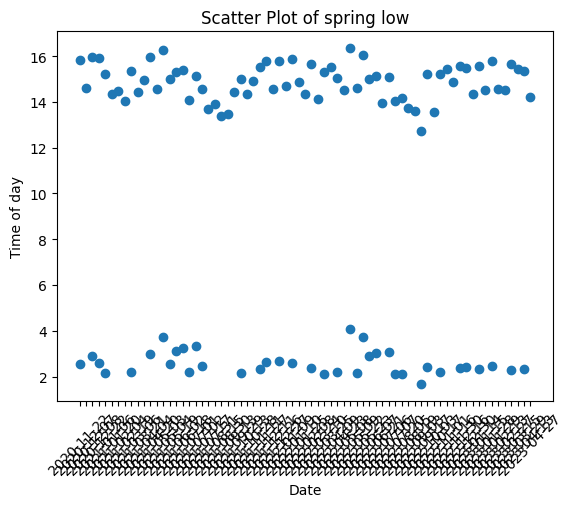

In [7]:
# Convert the 'time' column to datetime format
spring_lows['time'] = pd.to_datetime(spring_lows['time'], format='%H:%M:%S')

# Extract the time components (hour, minute, second)
spring_lows['hour'] = spring_lows['time'].dt.hour
spring_lows['minute'] = spring_lows['time'].dt.minute
spring_lows['second'] = spring_lows['time'].dt.second

# Create a numerical representation of time in hours
spring_lows['time_in_hours'] = spring_lows['hour'] + spring_lows['minute'] / 60 + spring_lows['second'] / 3600

# Create the scatter plot
plt.scatter(spring_lows['date'], spring_lows['time_in_hours'])
plt.xlabel('Date')
plt.ylabel('Time of day')
plt.title('Scatter Plot of spring low')
plt.xticks(rotation=45)
plt.show()

### This one gets the point accross and is quite pretty.

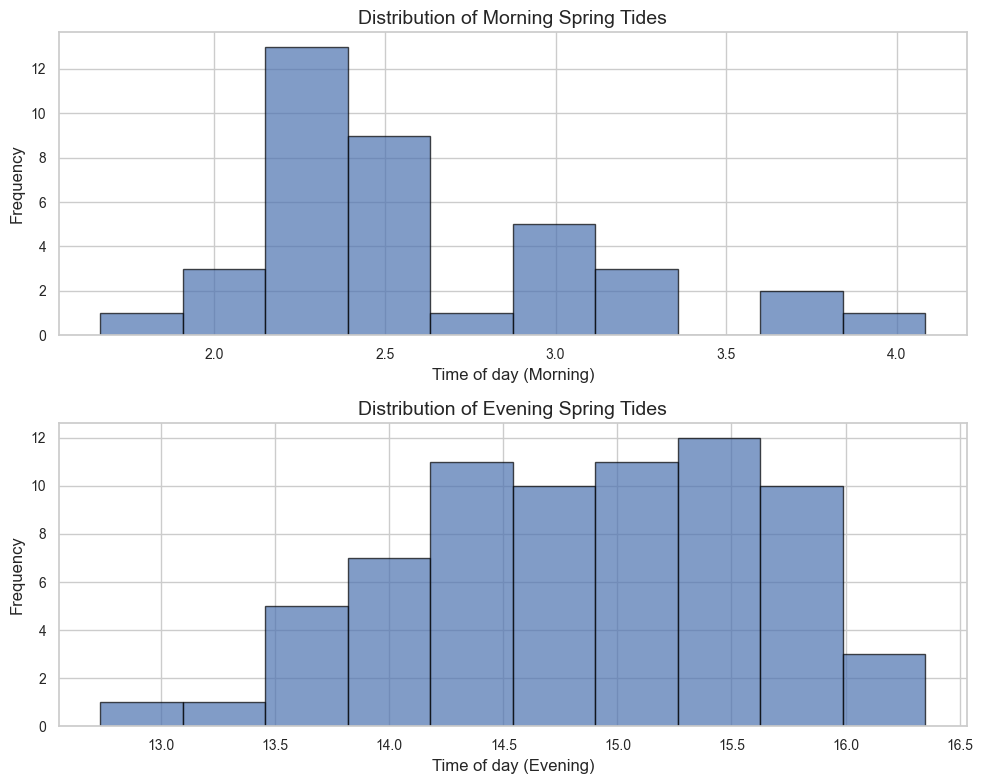

In [8]:

# Convert the 'time' column to datetime format
spring_lows['time'] = pd.to_datetime(spring_lows['time'], format='%H:%M:%S')

# Extract the time components (hour, minute, second)
spring_lows['hour'] = spring_lows['time'].dt.hour
spring_lows['minute'] = spring_lows['time'].dt.minute
spring_lows['second'] = spring_lows['time'].dt.second

# Create a numerical representation of time in hours
spring_lows['time_in_hours'] = spring_lows['hour'] + spring_lows['minute'] / 60 + spring_lows['second'] / 3600

# Separate morning and evening data
morning_data = spring_lows[spring_lows['hour'] < 12]
evening_data = spring_lows[spring_lows['hour'] >= 12]

# Set the professional style using seaborn
sns.set(style='whitegrid')

# Create a figure with subplots for morning and evening histograms
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot the morning histogram
ax1.hist(morning_data['time_in_hours'], bins=10, edgecolor='black', alpha=0.7)
ax1.set_xlabel('Time of day (Morning)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution of Morning Spring Tides', fontsize=14)
ax1.tick_params(axis='both', labelsize=10)

# Plot the evening histogram
ax2.hist(evening_data['time_in_hours'], bins=10, edgecolor='black', alpha=0.7)
ax2.set_xlabel('Time of day (Evening)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Distribution of Evening Spring Tides', fontsize=14)
ax2.tick_params(axis='both', labelsize=10)

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

### Put another way...

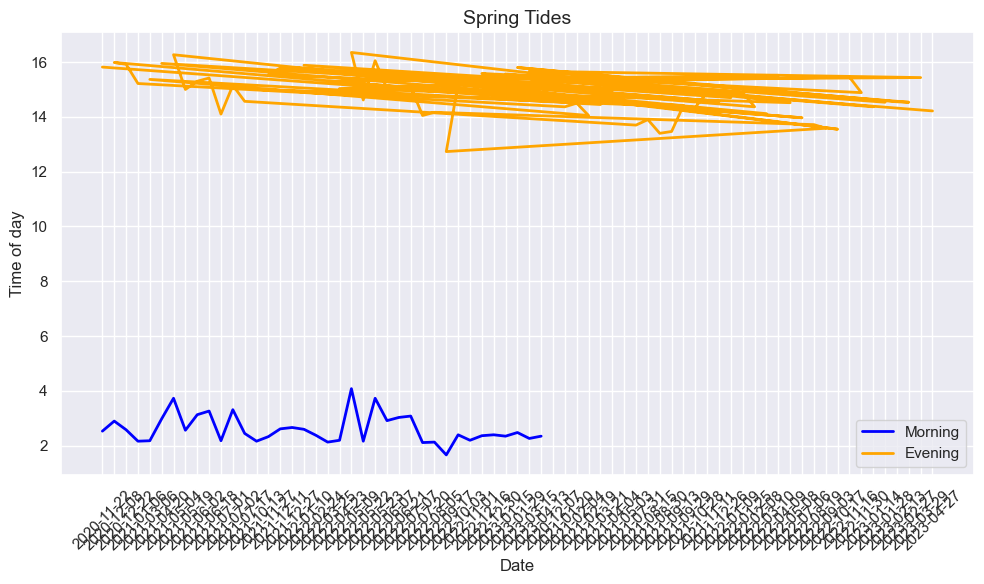

In [9]:

# Convert the 'time' column to datetime format
spring_lows['time'] = pd.to_datetime(spring_lows['time'], format='%H:%M:%S')

# Extract the time components (hour, minute, second)
spring_lows['hour'] = spring_lows['time'].dt.hour
spring_lows['minute'] = spring_lows['time'].dt.minute
spring_lows['second'] = spring_lows['time'].dt.second

# Create a numerical representation of time in hours
spring_lows['time_in_hours'] = spring_lows['hour'] + spring_lows['minute'] / 60 + spring_lows['second'] / 3600

# Separate morning and evening data
morning_data = spring_lows[spring_lows['hour'] < 12]
evening_data = spring_lows[spring_lows['hour'] >= 12]

# Set the professional style using seaborn
sns.set(style='darkgrid')

# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the morning line
ax.plot(morning_data['date'], morning_data['time_in_hours'], color='blue', linewidth=2, label='Morning')

# Plot the evening line
ax.plot(evening_data['date'], evening_data['time_in_hours'], color='orange', linewidth=2, label='Evening')

# Set x-axis label, y-axis label, and title
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Time of day', fontsize=12)
ax.set_title('Spring Tides', fontsize=14)

# Rotate x-axis tick labels for better readability
plt.xticks(rotation=45)

# Add a legend
ax.legend()

# Adjust the layout
plt.tight_layout()

# Display the plot
plt.show()

That's it hey! I think that's all there is to the story. <br>
I'm pretty confident in saying that he is right, it seems that the only surfable spring low in Cape Town is  <strong> reliably around 9 AM</strong>


## Here are some fun graphs I found along the way.

This one is not super informative, but I think it's fun and looks cool :)

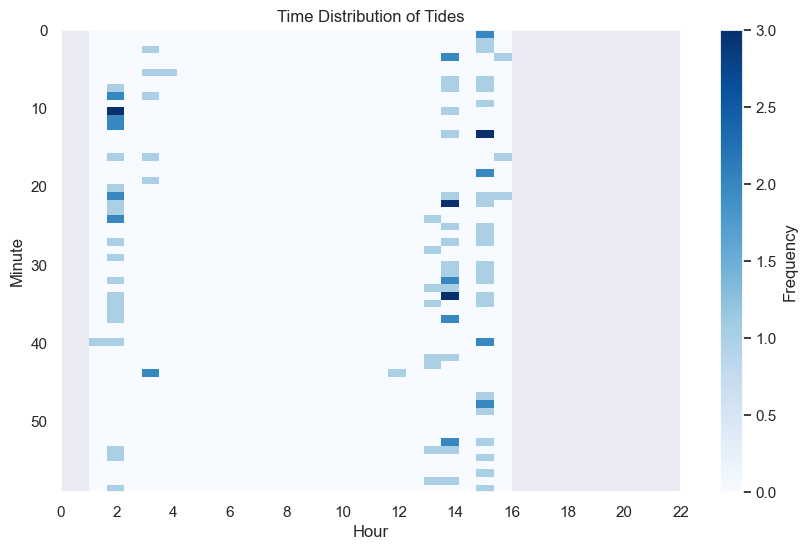

In [10]:
# Convert the time column to datetime
spring_lows['time'] = pd.to_datetime(spring_lows['time'])

# Extract the hour and minute components from the time
spring_lows['hour'] = spring_lows['time'].dt.hour
spring_lows['minute'] = spring_lows['time'].dt.minute

# Plot the time distribution of tides
plt.figure(figsize=(10, 6))
plt.hist2d(spring_lows['hour'], spring_lows['minute'], bins=[24, 60], cmap='Blues')
plt.colorbar(label='Frequency')
plt.xlabel('Hour')
plt.ylabel('Minute')
plt.title('Time Distribution of Tides')
plt.xticks(range(0, 24, 2))
plt.yticks(range(0, 60, 10))
plt.gca().invert_yaxis()
plt.show()

Another funky one

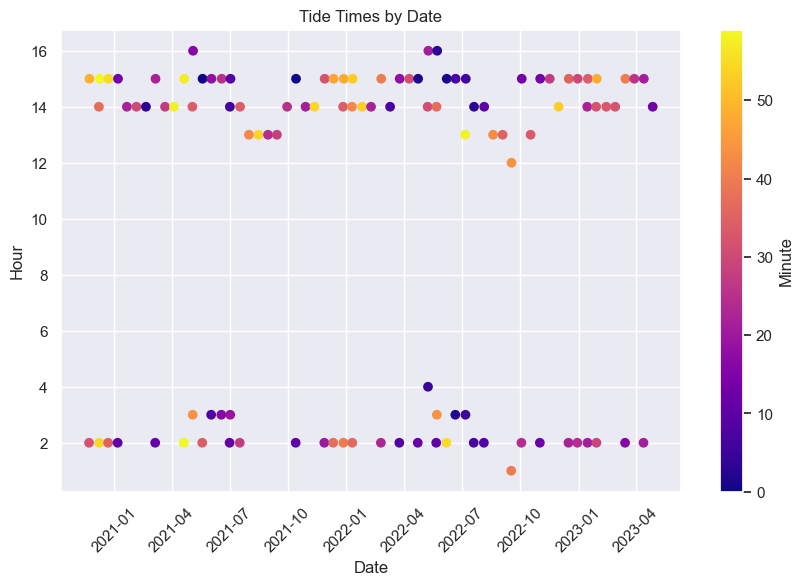

In [11]:
# Convert the date and time columns to datetime objects
spring_lows['date'] = spring_lows['date'].astype(str)
spring_lows['time'] = spring_lows['time'].astype(str)
spring_lows['datetime'] = pd.to_datetime(spring_lows['date'] + ' ' + spring_lows['time'])

# Extract the hour and minute components from the time
spring_lows['hour'] = spring_lows['datetime'].dt.hour
spring_lows['minute'] = spring_lows['datetime'].dt.minute

# Create a scatter plot of tide times by date
plt.figure(figsize=(10, 6))
plt.scatter(spring_lows['datetime'], spring_lows['hour'], c=spring_lows['minute'], cmap='plasma')
plt.colorbar(label='Minute')
plt.xlabel('Date')
plt.ylabel('Hour')
plt.title('Tide Times by Date')
plt.xticks(rotation=45)
plt.show()

This one has nothing to do with the mission at hand,  but I think it's quite interesting, looks like there's some correlation between month and tide height..<br>
Max tide height seems to be during Spring and Autumn, I wonder if this is why they call it springs...


<Figure size 1000x600 with 0 Axes>

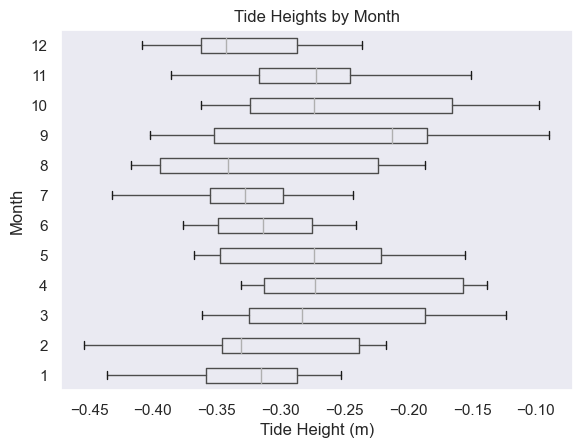

In [12]:
# Convert the date column to a datetime object
spring_lows['date'] = pd.to_datetime(spring_lows['date'])

# Extract the month component from the date
spring_lows['month'] = spring_lows['date'].dt.month

# Create a box plot of tide heights by month
plt.figure(figsize=(10, 6))
spring_lows.boxplot(column='height', by='month', grid=False, vert=False)
plt.xlabel('Tide Height (m)')
plt.ylabel('Month')
plt.title('Tide Heights by Month')
plt.suptitle('')
plt.show()

Another off topic and off kilter one.

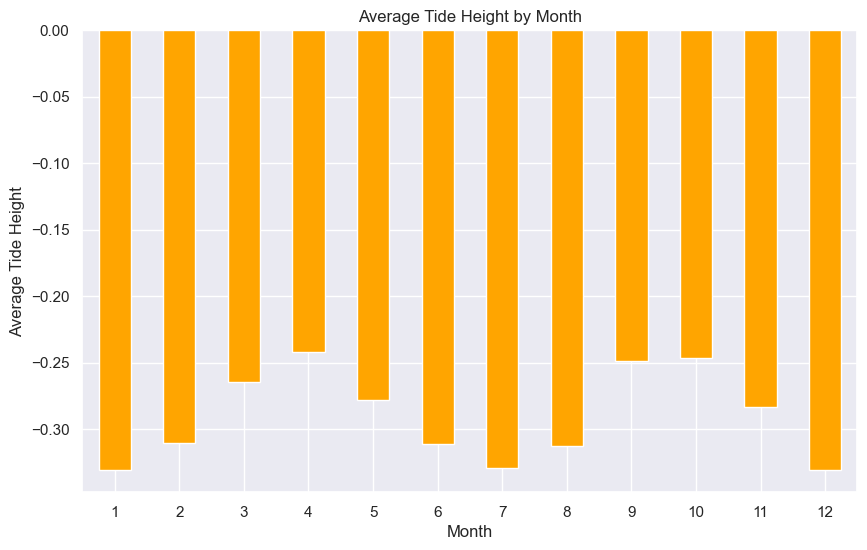

In [13]:
spring_lows['date'] = pd.to_datetime(spring_lows['date'])

# Extract the month from the date
spring_lows['month'] = spring_lows['date'].dt.month

# Calculate the average tide height for each month
monthly_avg = spring_lows.groupby('month')['height'].mean()

# Create a bar plot of average tide height by month
plt.figure(figsize=(10, 6))
monthly_avg.plot(kind='bar', color='orange')
plt.xlabel('Month')
plt.ylabel('Average Tide Height')
plt.title('Average Tide Height by Month')
plt.xticks(rotation=0)
plt.show()